In [1]:
use_dolfinx = True

### colab

In [2]:
import os
colab = os.getcwd() == "/content"
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [4]:
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx

In [ ]:
if colab:
    if use_dolfinx:
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

In [6]:
# !mpirun --allow-run-as-root --map-by slot:OVERSUBSCRIBE -np 4 python3 ns_dolfinx.py


In [7]:
from __future__ import print_function


In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()

  import tqdm.autonotebook



In [9]:
from IPython.display import clear_output as clc

plt.style.use("default")


In [10]:
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [11]:
from scipy.interpolate import RBFInterpolator

In [12]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [13]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [14]:
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [15]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Parameters

In [95]:
L = 10
H = 4
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
# N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

# Pinball parameters
R = 0.2
l = 3*R
centers = [[0.25*L, H/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 + l/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 - l/2]]

if colab:
    if use_dolfinx:
        mesh_comm = MPI.COMM_WORLD
        model_rank = 0
        gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 3
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

Re: 200.00


# Mesh generation

In [17]:
# Mesh parameters
# res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
res_min = 0.025
LcMin = res_min
LcMax = 0.05 * H # massima grandezza elementi vicino bordi della mesh
# LcMax = 0.1 * H
DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
DistMax = H # distanza dall'ostacolo in cui finisce il grading

# altre modifiche in generating the mesh
# res_min_wake = 0.005
res_min_wake = 0.05
LcMax_wake = 0.05 * H
DistMin_wake = res_min_wake * 3
DistMax_wake = H

# Fine mesh
generate_fine_mesh = True
write_fine_mesh = False
save_fine_mesh_numpy = True

# lref = f"cl{chord}_Aoa{Aoa}"
# name = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}"
# name_unsteady = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}_dt{dt}"
# name_mesh = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}"
# write_mesh = False
# save_mesh_numpy = True
# write_stokes = False
# write_ns = False
# write_ns_unsteady = False
# save_numpy = False

In [18]:
# x_airfoil, y_airfoil = (airfoil_coords[:, 0] + x_le).tolist(), (airfoil_coords[:, 1] + y_le).tolist()

In [19]:
# if mesh_comm.rank == model_rank:
    # Create rectangle domain
rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)

In [20]:
obstacle = []
for i, (xc, yc) in enumerate(centers, start=1):
    # 2.1 curva circolare
    cir = gmsh.model.occ.addCircle(xc, yc, 0, R, tag=10+i)
    # 2.2 chiudo il loop
    cl  = gmsh.model.occ.addCurveLoop([cir], tag=20+i)
    # 2.3 superficie disco
    surf = gmsh.model.occ.addPlaneSurface([cl], tag=30+i)
    obstacle.append((2, surf))   # tipo 2 = superficie


In [21]:
fluid = gmsh.model.occ.cut(
    [(2, rectangle)],   # oggetto
    obstacle            # “strumento” = i dischi
)
gmsh.model.occ.synchronize()

In [22]:
# points = []
# for i in range(len(x_airfoil)):
#     point = gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0)
#     points.append(point)
# points.append(points[0])
# spline = gmsh.model.occ.addSpline(points)
# # line_last_first = gmsh.model.occ.addLine(points[-1], points[0])
# # airfoil_curve = gmsh.model.occ.addCurveLoop([spline, line_last_first])
# airfoil_curve = gmsh.model.occ.addCurveLoop([spline])
# obstacle = gmsh.model.occ.addPlaneSurface([airfoil_curve])

In [23]:
p1 = gmsh.model.occ.addPoint(0.25*L + 3*R*np.sqrt(3)/2, 0.5*H, 0)
p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
horizontal_line = gmsh.model.occ.addLine(p1, p2)
gmsh.model.occ.synchronize()

In [24]:
# fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
# gmsh.model.occ.synchronize()

In [25]:
fluid_marker = 1
# if mesh_comm.rank == model_rank:
# Add physical volume marker
volumes = gmsh.model.getEntities(dim=gdim)
assert len(volumes) == 1
gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

In [26]:
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
# if mesh_comm.rank == model_rank:
boundaries = gmsh.model.getBoundary(volumes, oriented=False)
for boundary in boundaries:
    center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
    if np.allclose(center_of_mass, [0, H / 2, 0]):
        inflow.append(boundary[1])
    elif np.allclose(center_of_mass, [L, H / 2, 0]):
        outflow.append(boundary[1])
    elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
        center_of_mass, [L / 2, 0, 0]
    ):
        walls.append(boundary[1])
    else:
        obstacle.append(boundary[1])
gmsh.model.addPhysicalGroup(1, walls, wall_marker)
gmsh.model.setPhysicalName(1, wall_marker, "Walls")
gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [27]:
# res_min = 0.001
# if mesh_comm.rank == model_rank:

# Mesh Refinement con transfinite e grading
distance_field = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)

grading_field = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
# final_field = gmsh.model.mesh.field.add("Min")
# gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
# gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# Wake refinement
horizontal_line_field = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

final_field = gmsh.model.mesh.field.add("Min")
gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# Impostazioni avanzate per la mesh
gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
# gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
gmsh.option.setNumber("Mesh.RecombineAll", 0)
# gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

# Generazione e ottimizzazione
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.setOrder(1)
# gmsh.model.mesh.optimize("HighOrder")

# Salva la mesh
# gmsh.write("airfoil_mesh.msh")
# gmsh.finalize()

In [28]:
# if mesh_comm.rank == model_rank:
quality = gmsh.model.mesh.getNodes()
print(f"Generated {len(quality[0])} nodes.")


Generated 11437 nodes.


In [29]:
gdim

2

In [30]:
partitioner = dolfinx.mesh.create_cell_partitioner(dolfinx.mesh.GhostMode.shared_facet)

In [31]:
mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim, partitioner=partitioner)
ft = facet_tags
ft.name = "Facet markers"
cell_tags.name = "Cell markers"

In [32]:
# # # Get mesh topology and geometry
# topology, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim)

In [33]:
# with dolfinx.io.XDMFFile(mesh.comm, "mesh.xdmf", "w") as xdmf:
#     xdmf.write_mesh(mesh)
#     xdmf.write_meshtags(ft, mesh.geometry)


In [34]:
gmsh.write("pinball_mesh.msh")

# Utilities

In [35]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [36]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [37]:
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [38]:
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [39]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [40]:
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [41]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [42]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [43]:
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            U_max * np.cos(self.alpha)
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha, bcwalls="freeslip"):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle]

    # Outlet
    bcp_outlet = dirichletbc(
        PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    )
    bcp = [bcp_outlet]

    # Walls
    # freeslip
    if bcwalls=="freeslip":
        walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
        bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))
        bcu.append(bcu_walls)
    # noslip
    elif bcwalls=="freeslip":
        bcu_walls = dirichletbc(
            u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
        )
        bcu.append(bcu_walls)
    # freestream
    else:
        bcp_walls = dirichletbc(
            PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(wall_marker)), Q
        )
        bcp.append(bcp_walls)

    return bcu, bcp, u_inlet, inlet_velocity

In [44]:
def solve(params, mesh, facet_tags, dt, num_steps, mu_, rho_, save_to_np_every_steps = 10, bcwalls="freeslip"):

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max_0, alpha_0, bcwalls)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(mu_))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.LU)
    pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.LU)
    pc2.setFactorSolverType("mumps")
    solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.LU)
    pc3.setFactorSolverType("mumps")
    solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns_unsteady = Function(Q_vectorial)
    u_ns_unsteady.interpolate(u_)
    # newshape_ = (u_ns_unsteady.x.array[:].shape[0]//2, 2)
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, newshape = newshape_))
    U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))

    u_np = np.zeros_like(U[:, 0].reshape(1, -1))
    v_np = np.zeros_like(U[:, 1].reshape(1, -1))
    p_np = np.zeros_like(p_.x.array).reshape(1, -1)
    # u_mag_np = np.sqrt(u_np**2 + v_np**2)

    # u_torch = torch.zeros_like(U[:, 0]).reshape(1, -1)
    # v_torch = torch.zeros_like(U[:, 1]).reshape(1, -1)
    # p_torch = torch.zeros_like(torch.tensor(p_.x.array)).reshape(1, -1)

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0
    for i in range(num_steps):

        progress.update(1)

        # Update current time step
        t += dt

        print(f"timestep {i+1}, time {t}", ", ||u||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((u_)**2 * dx)), MPI.SUM)),
              ", ||p||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((p_)**2 * dx)), MPI.SUM)))

        # Update inlet velocity
        # inlet_velocity.t = t
        inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        # if save_numpy_unsteady:
        if i % save_to_np_every_steps == 0:
            # Save to np
            u_ns_unsteady.interpolate(u_)
            U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
            u_np = np.concatenate((u_np, U[:, 0].reshape(1, -1)), 0)
            v_np = np.concatenate((v_np, U[:, 1].reshape(1, -1)), 0)
            p_np = np.concatenate((p_np, p_.x.array.reshape(1, -1)), 0)
            # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # if i % save_to_torch_every_steps == 0:
        #     # Save to np
        #     u_ns_unsteady.interpolate(u_)
        #     U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))
        #     u_torch = torch.cat((u_torch, U[:, 0].reshape(1, -1)), 0)
        #     v_torch = torch.cat((v_torch, U[:, 1].reshape(1, -1)), 0)
        #     p_torch = torch.cat((p_torch, torch.tensor(p_.x.array.reshape(1, -1))), 0)
        #     # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

    progress.close()
    # return u_torch, v_torch, p_torch
    return u_np, v_np, p_np


# Snapshots generation

### Load pinball mesh

In [45]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

In [46]:
# # Load naca0012 mesh
# gmsh.initialize()
# gmsh.open("pinball_mesh.msh")

# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
# ft = facet_tags
# [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
# pinball_coords = np.array(obstacle_nodes)
# N_points = pinball_coords.shape[0]

# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Mesh has {len(quality[0])} nodes.")

In [47]:
# gmsh.finalize()

In [48]:
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
# pinball_coords = copy.deepcopy(pinball_coords)

In [49]:
# np.savez("data/pinball_data.npz", naca0012_airfoil_coords = pinball_coords, naca0012_coords = coords)

### Plot a snapshot

In [52]:
coords_data = np.load("data/pinball_data.npz")
pinball_coords = coords_data["pinball_coords"]
coords = coords_data["coords"]

In [54]:
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# Q = functionspace(mesh, s_cg1)
# coords = np.array(Q.tabulate_dof_coordinates())
x, y = coords[:, 0], coords[:, 1]
triang = tri.Triangulation(x, y)
x_tri = x[triang.triangles].mean(axis=1)
y_tri = y[triang.triangles].mean(axis=1)


cyl_coords = []
cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[0][0])**2 + (pinball_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[1][0])**2 + (pinball_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[2][0])**2 + (pinball_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])

In [128]:
snapshot = np.load("snapshots_pinball/snapshot_2.npz")
u = snapshot["u_np"]
v = snapshot["v_np"]
p = snapshot["p_np"]
params = snapshot["params"]

ntimes = u.shape[0]

In [129]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

# Calcola la magnitudine di u per tutti i timestep e determina min e max globali
u_all = np.sqrt(u**2 + v**2)
u_min, u_max = u_all.min(), u_all.max()
p_min, p_max = p[2:, :].min(), p[2:, ].max()

# Crea gli oggetti norm per fissare la scala dei colori
norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

# Crea due ScalarMappable per le colorbar statiche
sm_u = ScalarMappable(cmap='jet', norm=norm_u)
sm_u.set_array([])
sm_p = ScalarMappable(cmap='jet', norm=norm_p)
sm_p.set_array([])
# Imposta la figura con 2 sottotrame
scale = 2
nrows = 1
ncols = 2

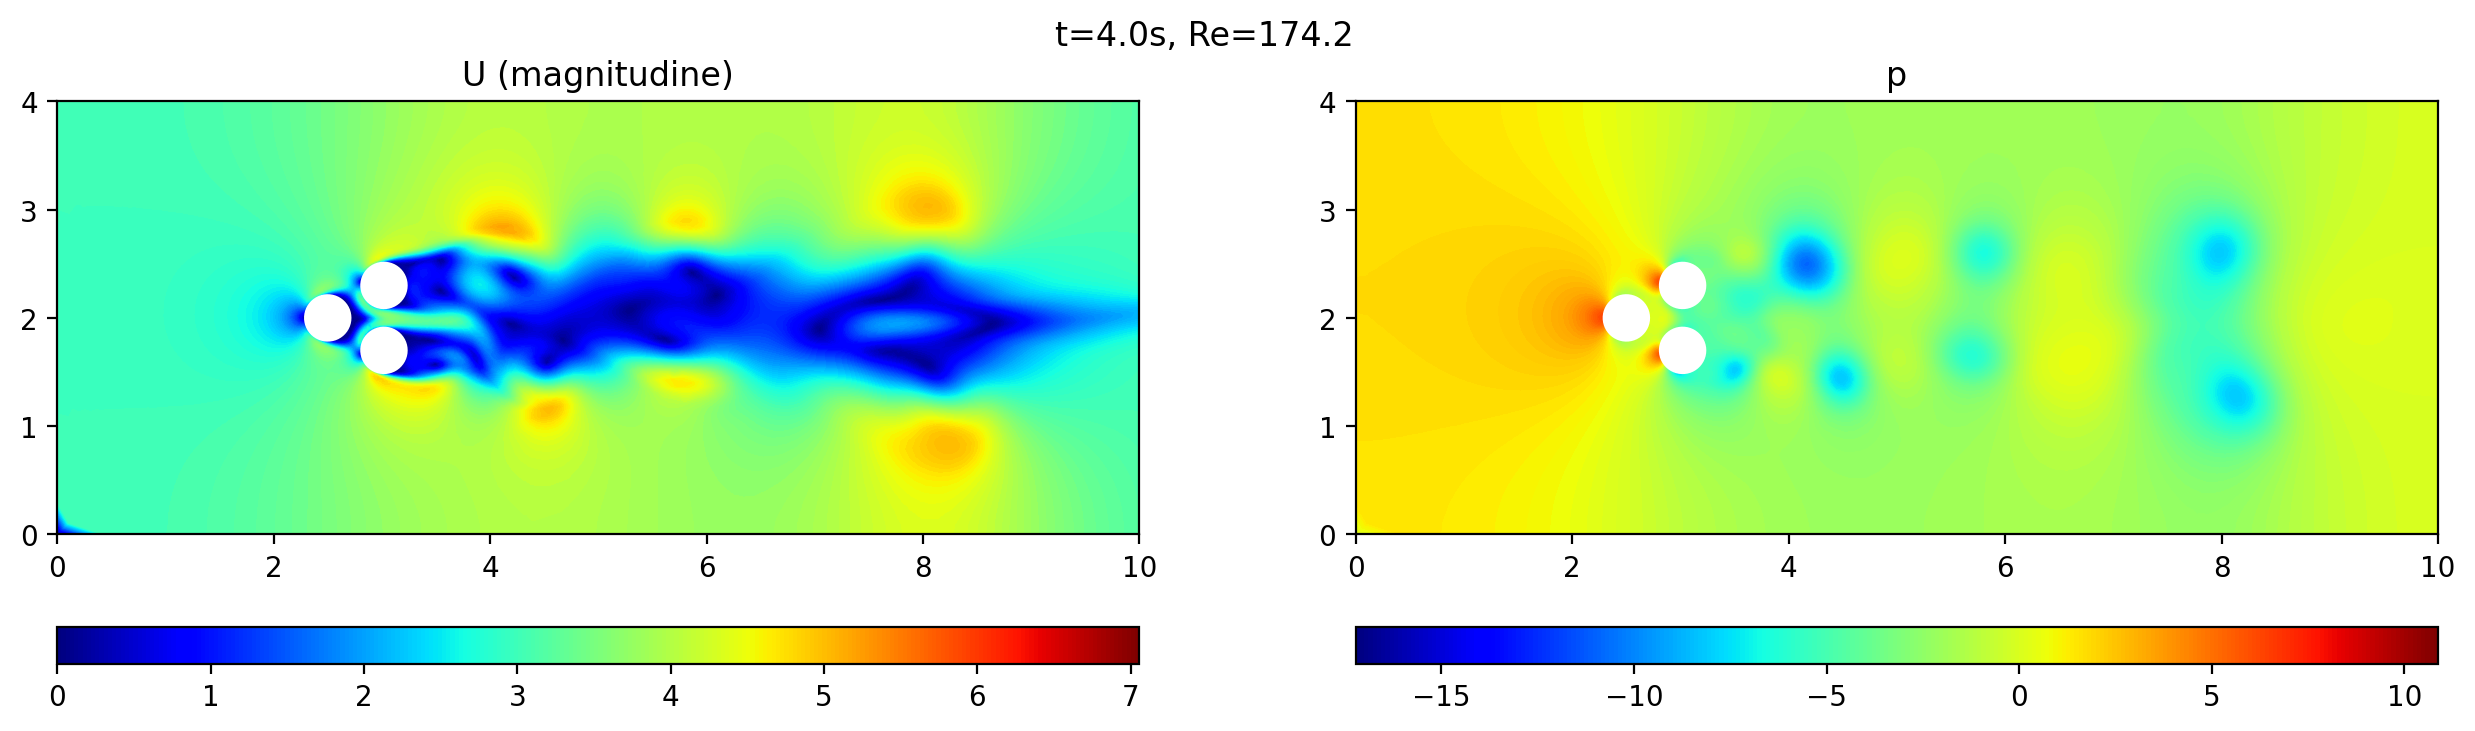

In [125]:
fig, axs = plt.subplots(nrows, ncols)

# add_zoom(2.4)

plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.35)
zoom = 2.4
plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

# Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
axs[0].set_title("U (magnitudine)")
cbar_p = fig.colorbar(sm_p, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
axs[1].set_title("p")

# whichtimes = np.arange(0, ntimes, 20).tolist()
whichtimes = [200]
for time in whichtimes:
    u_plot = u[time, :]
    v_plot = v[time, :]
    p_plot = p[time, :]

    u_mag = np.sqrt(u_plot**2 + v_plot**2)

    cont1 = axs[0].tricontourf(triang, u_mag, cmap="jet", levels=100, norm=norm_u)
    axs[0].set_aspect("equal")
    cont2 = axs[1].tricontourf(triang, p_plot, cmap="jet", levels=100, norm=norm_p)
    axs[1].set_aspect("equal")

    for ax in axs:
        for cyl in cyl_coords:
            ax.fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)

    # fig.subplots_adjust(top=2.95, bottom=0)
    fig.suptitle(f"t={time/400*8:.1f}s, Re={U_max * np.cos(params[0][0]) * 2 * R  * rho_ / params[1][0]:.1f} ")

    display(fig)
    plt.close(fig)
    clc(wait=True)


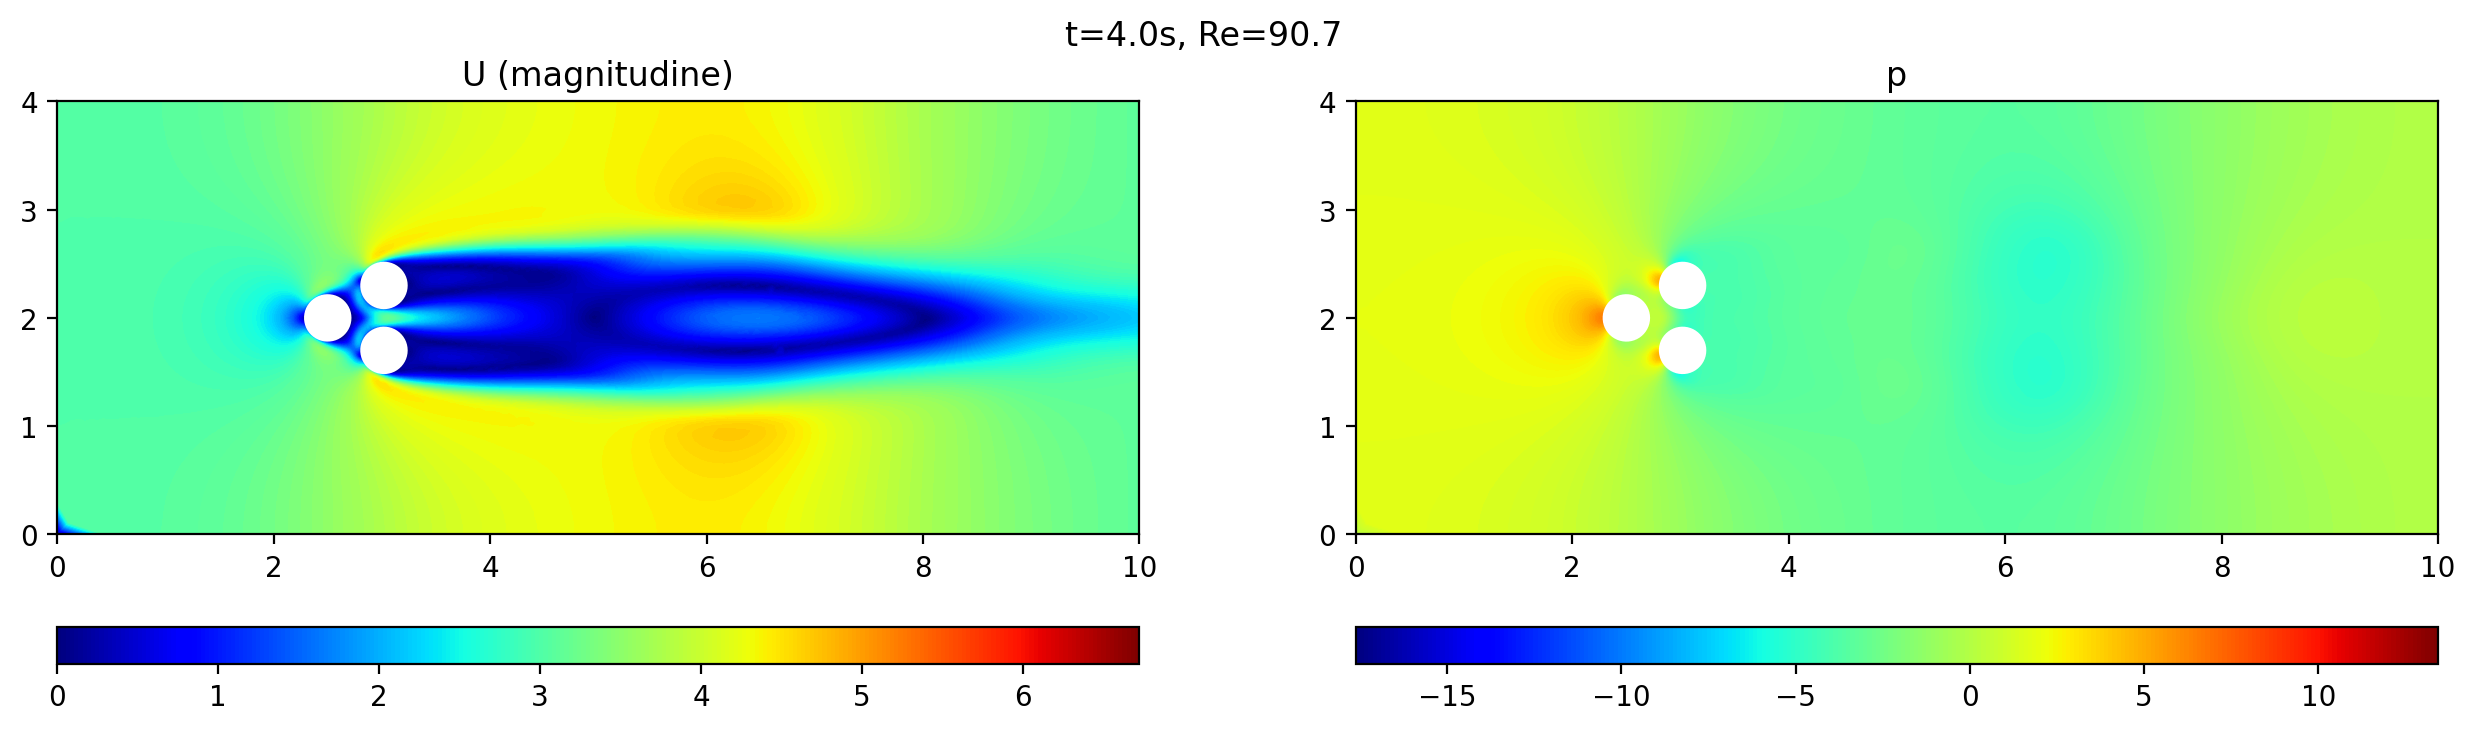

In [130]:
fig, axs = plt.subplots(nrows, ncols)

# add_zoom(2.4)

plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.35)
zoom = 2.4
plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

# Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
axs[0].set_title("U (magnitudine)")
cbar_p = fig.colorbar(sm_p, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
axs[1].set_title("p")

# whichtimes = np.arange(0, ntimes, 20).tolist()
whichtimes = [200]
for time in whichtimes:
    u_plot = u[time, :]
    v_plot = v[time, :]
    p_plot = p[time, :]

    u_mag = np.sqrt(u_plot**2 + v_plot**2)

    cont1 = axs[0].tricontourf(triang, u_mag, cmap="jet", levels=100, norm=norm_u)
    axs[0].set_aspect("equal")
    cont2 = axs[1].tricontourf(triang, p_plot, cmap="jet", levels=100, norm=norm_p)
    axs[1].set_aspect("equal")

    for ax in axs:
        for cyl in cyl_coords:
            ax.fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)

    # fig.subplots_adjust(top=2.95, bottom=0)
    fig.suptitle(f"t={time/400*8:.1f}s, Re={U_max * np.cos(params[0][0]) * 2 * R  * rho_ / params[1][0]:.1f} ")

    display(fig)
    plt.close(fig)
    clc(wait=True)


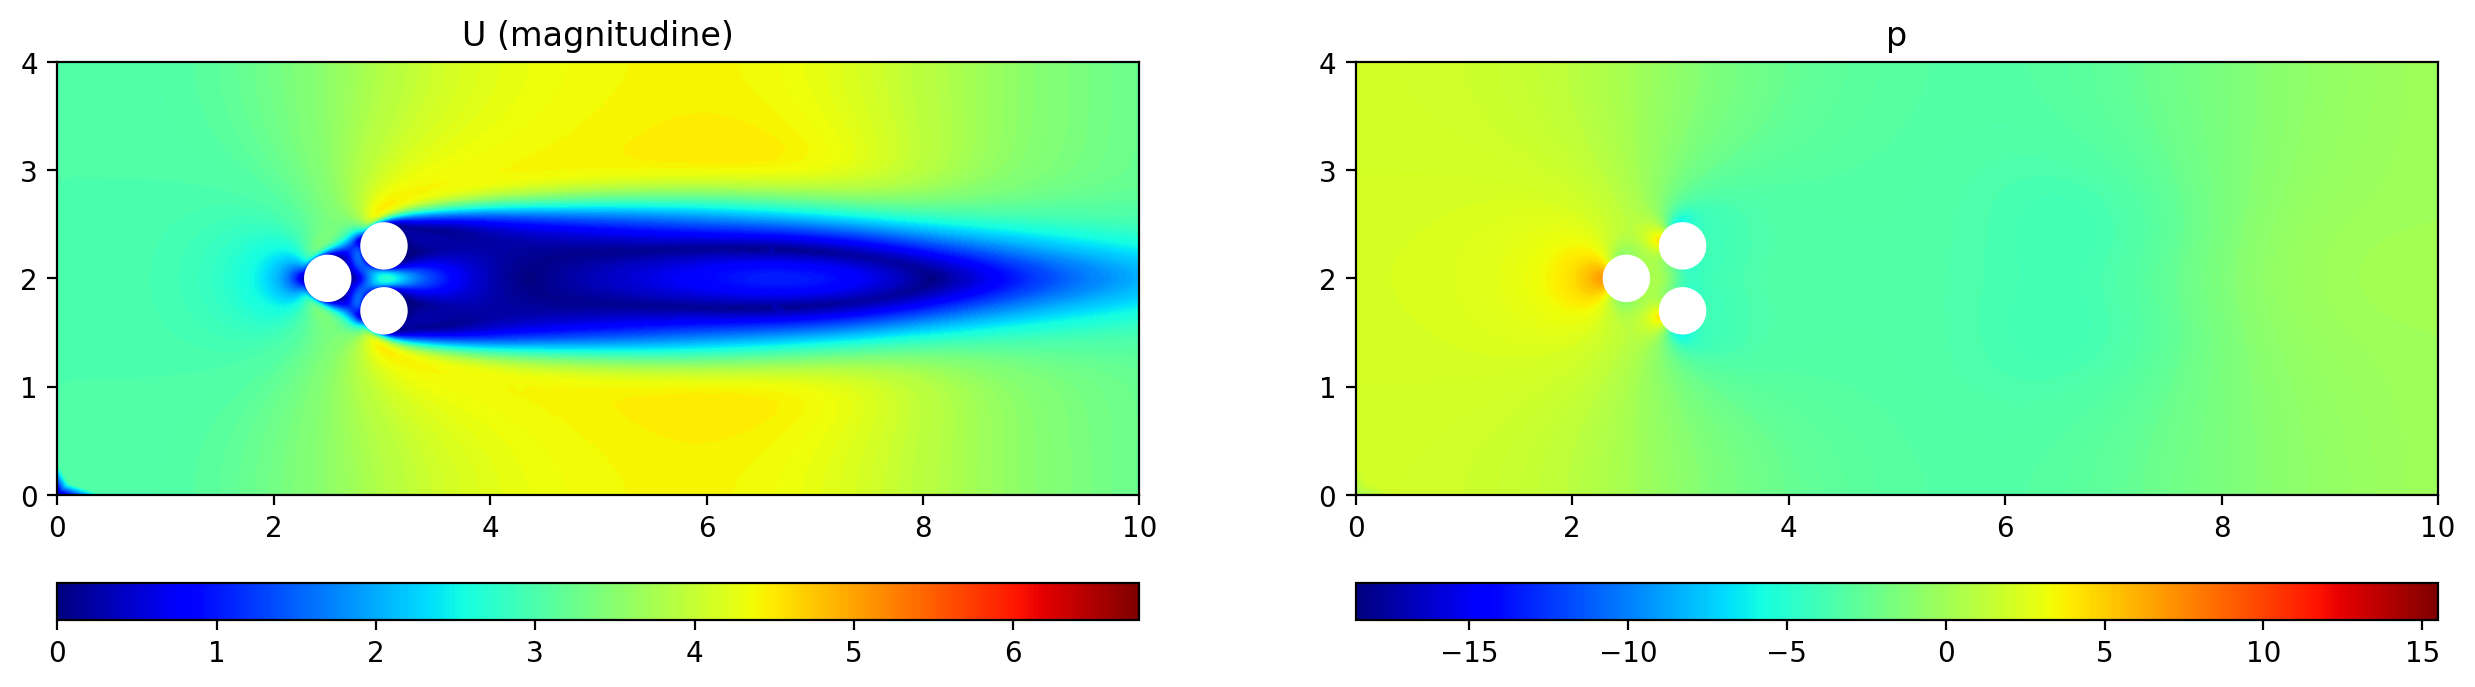

In [86]:
fig, axs = plt.subplots(nrows, ncols)

# add_zoom(2.4)

plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.35)
zoom = 2.4
plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

# Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
axs[0].set_title("U (magnitudine)")
cbar_p = fig.colorbar(sm_p, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
axs[1].set_title("p")

# whichtimes = np.arange(0, ntimes, 20).tolist()
whichtimes = [200]
for time in whichtimes:
    u_plot = u[time, :]
    v_plot = v[time, :]
    p_plot = p[time, :]

    u_mag = np.sqrt(u_plot**2 + v_plot**2)

    cont1 = axs[0].tricontourf(triang, u_mag, cmap="jet", levels=100, norm=norm_u)
    axs[0].set_aspect("equal")
    cont2 = axs[1].tricontourf(triang, p_plot, cmap="jet", levels=100, norm=norm_p)
    axs[1].set_aspect("equal")

    for ax in axs:
        for cyl in cyl_coords:
            ax.fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)

    # fig.subplots_adjust(top=2.95, bottom=0)
    fig.suptitle(f"t={time/400*8:.1f}s, Re={U_max * np.cos(params[0][0]) * 2 * R  * rho_ / params[1][0]:.1f} ")

    display(fig)
    plt.close(fig)
    clc(wait=True)
